# Section 1: Business Understanding
In this netbook we will look through Airbnb data for the city of Seattle. We will attempts to answer the following questions

#### Question 1:Where- what locations are most popular
#### Question 2:When- what time of the year is the busiest in Seattle
#### Question 3:Cost- can we find some ways to get a little better value out of our rental

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Section 2: Data Understanding

#### Gather

In [2]:
#Import the data
calendar_df = pd.read_csv('Data/calendar.csv')
listings_df = pd.read_csv('Data/listings.csv')
reviews_df = pd.read_csv('Data/reviews.csv',parse_dates=['date'])

In [10]:
print(calendar_df.shape)
print(listings_df.shape)
print(reviews_df.shape)

(1393570, 4)
(3818, 92)
(84849, 6)


In [16]:
print("calendar_df columns")
print(calendar_df.columns)
print("\nlistings_df columns")
print(listings_df.columns)
print("\nreviews_df columns")
print(reviews_df.columns)

calendar_df columns
Index(['listing_id', 'date', 'available', 'price'], dtype='object')

listings_df columns
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'pr

In [25]:
print(listings_df[['bathrooms','bedrooms','beds','host_total_listings_count','neighbourhood']].dtypes)
print('\n')
print(reviews_df[['listing_id','date']].dtypes)
print('\n')

bathrooms                    float64
bedrooms                     float64
beds                         float64
host_total_listings_count    float64
neighbourhood                 object
dtype: object


listing_id             int64
date          datetime64[ns]
dtype: object




# Section 3: Data Preparation

#### Question 1 - Where

In [7]:
#We only need the neighborhoods column and can make a new dataframe base on the count of this column
area = listings_df[['neighbourhood']]
area_count = area['neighbourhood'].value_counts()
top_areas = pd.DataFrame({'Neighbourhood': area_count.index[:10],
                          'Count': area_count.iloc[:10].values
                         })

#### Question 2 - When

In [8]:
#Grab only the needed columns
rev = reviews_df[['listing_id','date']]
#Filering for only 2015 as this is the most recent, complete year in the data
rev = rev[rev['date'].dt.year == 2015]
#add a column for which month it is
rev['Month'] = rev['date'].dt.strftime('%b')
#Creating a new dataframe to make the graph from
rev_freq = pd.DataFrame(rev['Month'].value_counts().values,
                        index=rev['Month'].value_counts().index,
                        columns=['num_of_reviews'])

rev_freq.index.name = 'Month'
#Rearranging the ordedr to be chronological 
new_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
rev_freq = rev_freq.reindex(new_order, axis=0)

### Question 3 - Cost

In [26]:
#Change index to allow merging
listings_df = listings_df.rename(index=str, columns={'id': 'listing_id'})
#And then merge
combined_df = pd.merge(calendar_df, listings_df, on = 'listing_id')

#Now to drop all the rows that do not have a price_x as this is our predictor
combined_df = combined_df.dropna(subset=['price_x'])

#Create a new dataframe of just the values I can use 
df = combined_df[['bathrooms','bedrooms','beds','date','host_total_listings_count',
                  'number_of_reviews','review_scores_rating','price_x']].copy()

In [27]:
#First check for nan's
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
date,date,0.000000
number_of_reviews,number_of_reviews,0.000000
price_x,price_x,0.000000
host_total_listings_count,host_total_listings_count,0.009844
beds,beds,0.039057
bedrooms,bedrooms,0.214330
bathrooms,bathrooms,0.513942
review_scores_rating,review_scores_rating,15.466079


In [28]:
#The following columns will all fill in nan with the mode
cols = ['bathrooms','bedrooms','beds','host_total_listings_count']
df[cols]=df[cols].fillna(df.mode().iloc[0])
#Nan for review score will use the mean
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].mean())
#Convert date to datetime object, get the month, drop original date column
df['date'] = pd.to_datetime(df['date'])
df['month_of_date'] = df['date'].dt.month
df = df.drop(columns = ['date'])
#Convert price to a string, remove non nummerical values, delete original column
df['price'] = df[['price_x']].astype(str)
df['price'] = df[['price']].replace('[$, ]','',regex=True).astype(float)
df = df.drop(columns = ['price_x'])
#Trying some feature engineering I saw in a kaggle competition
#It didn't add to much value to the model, but I thought it was nice to keep in
df['engineered_review'] = df['number_of_reviews'] * df['review_scores_rating']
df['engineered_review_2'] = df['number_of_reviews'] * df['review_scores_rating'] * df['review_scores_rating']

# Section 4: Modeling

In [29]:
#Split out our X and y variables and then create train test splits
X = df.drop(columns='price')
y = df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

#It's always a good idea to scale your data
sc = StandardScaler()
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 

#Using a random forest regressor as this gave the best results
reg = RandomForestRegressor(n_estimators=100,
                            criterion='mse',
                            random_state=42,
                            n_jobs=-1)

reg.fit(X_train,y_train.squeeze())

#Getting the predicted values and seeing how well out model scored
y_train_preds = reg.predict(X_train)
y_test_preds = reg.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 1168.812, test: 1215.468
Random Forest R^2 train: 0.895, test: 0.888


# Section 5: Evaluate the Results
#### Question 1:Where- what locations are most popular

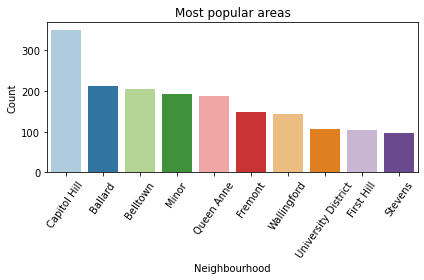

In [30]:
sns.barplot(x=top_areas.Neighbourhood,y=top_areas.Count,palette='Paired')

plt.title('Most popular areas')
plt.xticks(rotation=55)
plt.tight_layout()
plt.savefig('Neigh_count.png',dpi=300)
plt.savefig('Neigh_count_jpg.jpg',dpi=300)

In [31]:
#Captiol Hill is the most popular location in Seattle to rent

#### Question 2:When- what time of the year is the busiest in Seattle

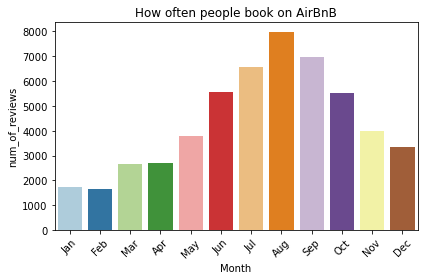

In [32]:
#Creating a boxplot to display the results
sns.barplot(x=rev_freq.index,y=rev_freq.num_of_reviews,palette='Paired');

plt.title('How often people book on AirBnB');
plt.xticks(rotation=45);
plt.tight_layout()
plt.savefig('Seattle_time_review.png',dpi=300)
plt.savefig('Seattle_time_review_jpg.jpg',dpi=300)

In [33]:
#Summer months and winter holidays are the more popular vacation times. 

#### Question 3:Cost- can we find some ways to get a little better value out of our rental

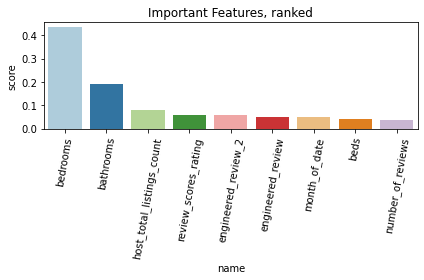

In [35]:
#To visiualize the important porameters I need to get them in a dataframe
headers = ["name", "score"]
values = sorted(zip(X.columns, reg.feature_importances_), key=lambda x: x[1] * -1)
important_features = pd.DataFrame(values, columns = headers)
important_features = important_features.sort_values(by = ['score'], ascending = False)

#Now to graph the results
sns.barplot(x=important_features.name,y=important_features.score,palette='Paired')

plt.title('Important Features, ranked')
plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig('Important_Features.png',dpi=300)
plt.savefig('Important_Features_jpg.jpg',dpi=300)

In [ ]:
#The number of bedrooms and bathrooms are the most significant factors in price. 
#This is likely due to the correlation to them and the size of the rental. 